<a href="https://colab.research.google.com/github/bijumanvya/Indix/blob/master/Codeblocks_with_results_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Discretization (Binning)
Goal:- Convert continuous age into categories like “Young”, “Mid-age”, “Senior”.

Cell 1: Import Libraries and Setup

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
filePath='/content/drive/MyDrive/BITS PILANI/bank-full.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df_bank=pd.read_csv(filePath,sep=';')

In [1]:
# STEP 1: Import the required Python libraries


import matplotlib.pyplot as plt        # For visualizations
import seaborn as sns                  # For advanced plotting
import warnings                        # To suppress warnings (for cleaner output)

# FutureWarning is a harmless warning from Seaborn. Let's suppress it.
warnings.simplefilter(action='ignore', category=FutureWarning)


Cell 2: Load the Dataset

Bank Datset Overview
Bank Marketing Dataset – Brief Overview
Source: Portuguese retail bank.


Columns: 17

Goal: Predict whether a client will subscribe to a term deposit (y = yes/no).

Key Features in the Dataset
Client Info
age: Customer’s age

job, marital, education: Socio-demographic variables

default: Credit default

balance: Average yearly account balance

housing, loan: Has housing/personal loan?

Campaign Interaction
contact: Contact communication type (e.g., cellular, telephone)

day, month: Date of last contact

duration: Call duration in seconds

Campaign History
campaign: Number of contacts during this campaign

pdays: Days since last contact from a previous campaign (-1 means never contacted)

previous: Number of contacts in previous campaigns

poutcome: Outcome of the previous marketing campaign

Target Variable
y: Whether the client subscribed to a term deposit

In [12]:
# Let's look at the first 5 rows to understand the structure
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Cell 3: Focus on Age Column

In [14]:
 #STEP 3: Extract the 'age' column to perform binning

# We are going to group ages into categories.
ages = df_bank['age']

# Check the minimum and maximum ages to understand the range
print("Minimum age:", ages.min())
print("Maximum age:", ages.max())
#

Minimum age: 18
Maximum age: 95


#Equal Width Binning

In [15]:
# STEP 4: Equal-Width Binning (Divide age range into 4 equal intervals)

# We divide the entire age range into 4 equal parts using pd.cut().
# We assign meaningful labels to each age group for readability.
df_bank['age_bin_width'] = pd.cut(
    ages,
    bins=4,  # 4 intervals of equal width
    labels=['Young', 'Adult', 'Mature', 'Senior']
)

# Let's check how the binning looks
df_bank[['age', 'age_bin_width']].head(10)


,age,age_bin_width
0,58,Mature
1,44,Adult
2,33,Young
3,47,Adult
4,33,Young
5,35,Young
6,28,Young
7,42,Adult
8,58,Mature
9,43,Adult


Cell 5: Equal-Frequency Binning

In [16]:
# STEP 5: Equal-Frequency Binning (Each bin has ~25% of the data)

# This uses pd.qcut(), which splits data based on percentiles (quartiles here).
# This ensures that each bin has a roughly equal number of people.
df_bank['age_bin_freq'] = pd.qcut(
    ages,
    q=4,  # 4 equal-frequency bins
    labels=['Q1', 'Q2', 'Q3', 'Q4']
)

# Let's check how this looks along with previous binning
df_bank[['age', 'age_bin_width', 'age_bin_freq']].head(10)


,age,age_bin_width,age_bin_freq
0,58,Mature,Q4
1,44,Adult,Q3
2,33,Young,Q1
3,47,Adult,Q3
4,33,Young,Q1
5,35,Young,Q2
6,28,Young,Q1
7,42,Adult,Q3
8,58,Mature,Q4
9,43,Adult,Q3


Cell 6: Visualize Age Group Distributions

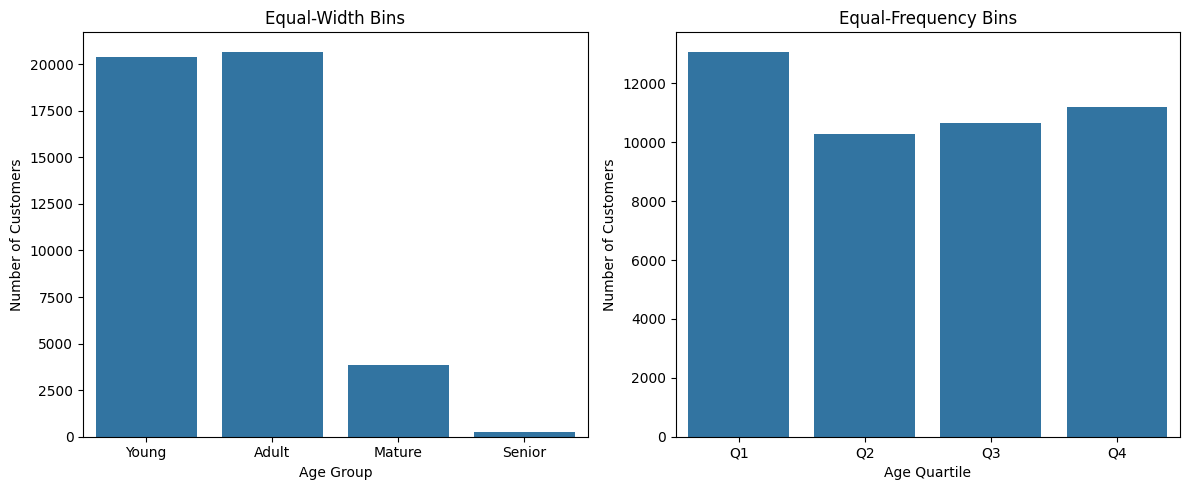

In [17]:
# STEP 6: Visualize the distribution of age bins using bar plots

# We'll create side-by-side plots to compare both binning methods.

# Set up a 1-row, 2-column subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Equal-Width Binning
sns.countplot(x='age_bin_width', data=df_bank, ax=axes[0])
axes[0].set_title('Equal-Width Bins')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Number of Customers')

# Plot 2: Equal-Frequency Binning
sns.countplot(x='age_bin_freq', data=df_bank, ax=axes[1])
axes[1].set_title('Equal-Frequency Bins')
axes[1].set_xlabel('Age Quartile')
axes[1].set_ylabel('Number of Customers')

# Show plots
plt.tight_layout()
plt.show()

Cell 7: Final Insights

In [ ]:
# STEP 7: What did we learn?

# 1. Equal-width binning divides the range of ages into equal intervals,
#    but it might result in unbalanced bins if the data is skewed.

# 2. Equal-frequency binning ensures each group has the same number of records,
#    but the width (range) of each bin can vary.

# When to use which?
# - Use equal-width when the data is uniformly spread.
# - Use equal-frequency when you want balanced group sizes for modeling or visualization.


#Binarization
Goal: Create a binary flag is_senior if age > 60.

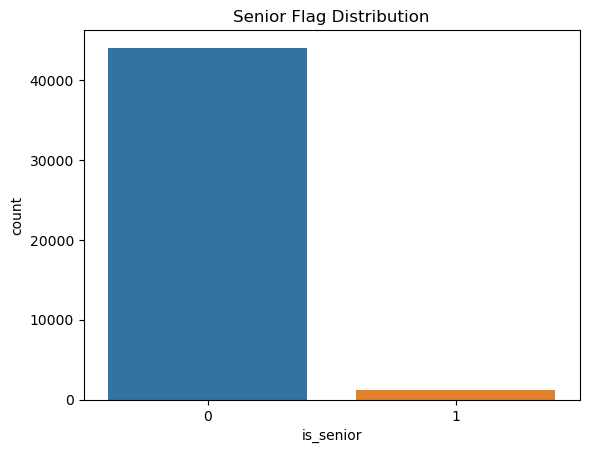

In [ ]:
# Binary flag based on threshold
df_bank['is_senior'] = (df_bank['age'] > 60).astype(int)

# View distribution
sns.countplot(x='is_senior', data=df_bank).set_title('Senior Flag Distribution')
plt.show()

#Why: Flags like is_senior simplify feature space and facilitate decision-making in models.
#Impact: Adds interpretability; e.g., helps models easily learn age-related risk.

#Normalization & Standardization
Goal: Compare effects on KNN using Min-Max vs Z-score scaling.

In [21]:

filePath='/content/drive/MyDrive/BITS PILANI/winequality-red.csv'
df_wine=pd.read_csv(filePath,sep=',')

In [22]:
# STEP 1: Import all required libraries

import pandas as pd                               # For handling dataframes
import numpy as np                                # For numerical operations
from sklearn.preprocessing import MinMaxScaler, StandardScaler   # For scaling
from sklearn.neighbors import KNeighborsClassifier              # KNN model
from sklearn.model_selection import train_test_split            # For splitting dataset

Cell 2: Load the Wine Quality Dataset

In [23]:
# STEP 2: Load the wine quality dataset



# Separate features (X) and target (y)
X = df_wine.drop('quality', axis=1)  # All columns except 'quality'
y = df_wine['quality']               # Only the 'quality' column


Cell 3: Split the Data into Training and Testing Sets

In [24]:
# STEP 3: Split the dataset into training and testing sets

# This ensures we train the model on one portion of data and test on unseen data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#  test_size=0.25 means 25% of data goes to testing, 75% to training
# random_state ensures reproducibility


Cell 4: Apply Min-Max Normalization

In [25]:
# STEP 4: Apply Min-Max Normalization

# Min-Max Scaler scales all feature values between 0 and 1
# Useful when you want to preserve shape and not assume Gaussian distribution

mm = MinMaxScaler()

# Fit the scaler on training data and transform both train and test
X_train_mm = mm.fit_transform(X_train_raw)
X_test_mm = mm.transform(X_test_raw)


Cell 5: Apply Z-score Standardization

In [26]:
# STEP 5: Apply Z-score Standardization

# Z-score scaling (StandardScaler) transforms features to have:
# - Mean = 0
# - Standard Deviation = 1
# Useful when features have different scales or units

ss = StandardScaler()

# Fit and transform the training set; transform the test set
X_train_ss = ss.fit_transform(X_train_raw)
X_test_ss = ss.transform(X_test_raw)


Cell 6: Define KNN Evaluation Function

In [27]:
# STEP 6: Define a function to train and evaluate KNN

def eval_knn(X_train, X_test):
    # Create KNN model with k=5
    knn = KNeighborsClassifier(n_neighbors=5)

    # Fit model on training data
    knn.fit(X_train, y_train)

    # Return model accuracy on test data
    return knn.score(X_test, y_test)


Cell 7: Compare Accuracies Across Raw vs Scaled Data

In [28]:
# STEP 7: Evaluate the KNN classifier using different versions of the data

# KNN is a distance-based algorithm — scaling impacts performance significantly

print("Raw KNN accuracy:", eval_knn(X_train_raw, X_test_raw))     # Without scaling
print("Min-Max scaled accuracy:", eval_knn(X_train_mm, X_test_mm))  # With Min-Max scaling
print("Z-score scaled accuracy:", eval_knn(X_train_ss, X_test_ss))  # With Z-score scaling


Raw KNN accuracy: 0.4675
Min-Max scaled accuracy: 0.55
Z-score scaled accuracy: 0.5775


Cell 8: Visual Comparison of Accuracy (Bar Plot)

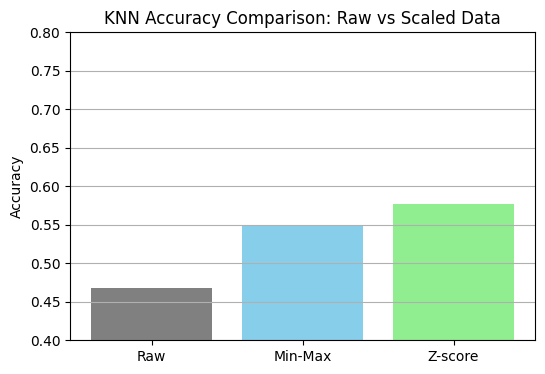

In [29]:
# STEP 8: Visualize the impact of scaling on KNN accuracy

import matplotlib.pyplot as plt

# Create labels and accuracy list
methods = ['Raw', 'Min-Max', 'Z-score']
accuracies = [
    eval_knn(X_train_raw, X_test_raw),
    eval_knn(X_train_mm, X_test_mm),
    eval_knn(X_train_ss, X_test_ss)
]

# Create bar chart
plt.figure(figsize=(6, 4))
plt.bar(methods, accuracies, color=['gray', 'skyblue', 'lightgreen'])
plt.title("KNN Accuracy Comparison: Raw vs Scaled Data")
plt.ylabel("Accuracy")
plt.ylim(0.4, 0.8)
plt.grid(axis='y')
plt.show()

#Since KNN is a distance-based algorithm, scaling has a huge impact on the final model performance.
#We can see how unscaled features hurt accuracy, while both scaling techniques help, especially Z-score in this dataset."

Cell 9: Interpretation

In [ ]:
# STEP 9: Key Takeaways

# - Without scaling, KNN may perform poorly because features with large values dominate the distance calculation.
# - Min-Max scaling compresses all features between 0–1, which helps equalize feature influence.
# - Z-score standardization centers features and helps when data is normally distributed.

# In practice, always apply scaling for KNN, SVM, and other distance-based algorithms.

#Learning:

#Why: Modeling without scaling can bias distance metrics toward large-scale features.

#Impact: Expect improved accuracy with both scalers—especially Min-Max—for KNN.

Smoothing (Moving Average)
Goal: Apply rolling mean to daily sales data.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Step 1: Create Simulated Sales Data with Noise
# --------------------------

# Set seed for reproducibility
np.random.seed(42)

# Create a date range
dates = pd.date_range(start='2021-01-01', periods=100)

# Generate daily sales with trend + noise (more realistic simulation)
# Cumulative sum adds trending behavior, noise simulates real-world daily fluctuation
sales_values = np.cumsum(np.random.randn(100) * 50 + 200)

# Create the simulated sales dataset
sales = pd.DataFrame({'Date': dates, 'Sales': sales_values})

# Show the first 5 rows of the dataset to students
print("Preview of the Sales Dataset:")
print(sales.head())

Preview of the Sales Dataset:
        Date        Sales
0 2021-01-01   224.835708
1 2021-01-02   417.922493
2 2021-01-03   650.306919
3 2021-01-04   926.458412
4 2021-01-05  1114.750744


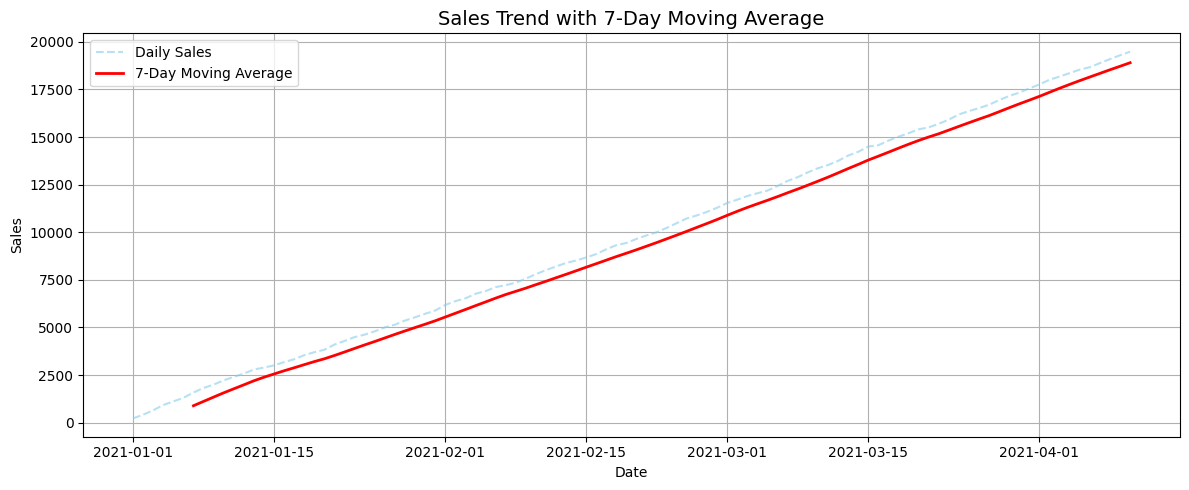

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Step 1: Create Simulated Sales Data with Noise
# --------------------------

# Set seed for reproducibility
np.random.seed(42)

# Create a date range
dates = pd.date_range(start='2021-01-01', periods=100)

# Generate daily sales with trend + noise (more realistic simulation)
# Cumulative sum adds trending behavior, noise simulates real-world daily fluctuation
sales_values = np.cumsum(np.random.randn(100) * 50 + 200)

# Create DataFrame
sales = pd.DataFrame({'Date': dates, 'Sales': sales_values})

# --------------------------
# Step 2: Calculate 7-Day Moving Average
# --------------------------

# Rolling mean smooths the sales data over a 7-day window
sales['Sales_7day_MA'] = sales['Sales'].rolling(window=7).mean()

# --------------------------
# Step 3: Plot the Results
# --------------------------

plt.figure(figsize=(12, 5))

# Plot daily sales (raw, noisy data)
plt.plot(sales['Date'], sales['Sales'], label='Daily Sales', color='skyblue', linestyle='--', alpha=0.6)

# Plot 7-day moving average (smooth trend)
plt.plot(sales['Date'], sales['Sales_7day_MA'], label='7-Day Moving Average', color='red', linewidth=2)

plt.title("Sales Trend with 7-Day Moving Average", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Notes:
# --------------------------
# Daily Sales (blue dashed): Shows real-time variation, includes short-term noise.
# 7-Day Moving Average (red): Smooths the noise, highlights long-term trends.
# Purpose: Helps in trend analysis, decision making, and forecasting.

# Analogy:
#     - Daily Sales = Daily temperature (fluctuates)
#     - 7-Day MA = Weekly climate pattern (more stable)

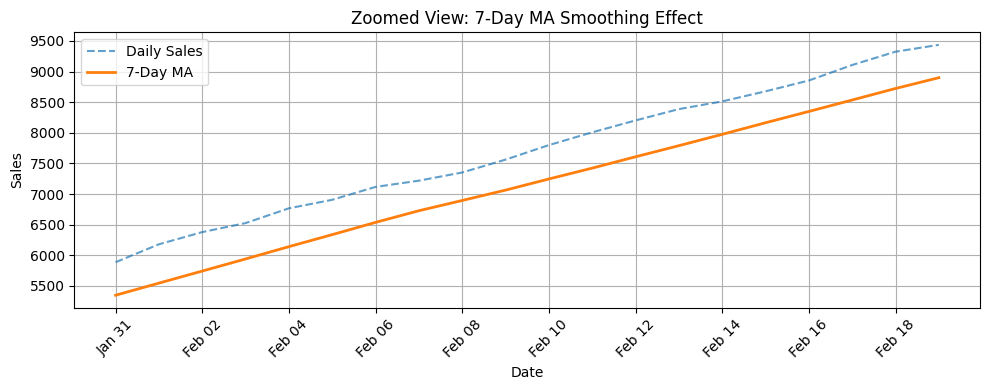

In [ ]:
# --------------------------
# Step 4: Zoomed-In Visualization
# --------------------------

# Focus on a smaller time window (e.g., day 30 to day 50)
# This allows closer inspection of how the Moving Average smooths out daily fluctuations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #Needed for formatting x-axis dates

sales_zoom = sales.iloc[30:50]

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(sales_zoom['Date'], sales_zoom['Sales'], label='Daily Sales', linestyle='--', alpha=0.7)
plt.plot(sales_zoom['Date'], sales_zoom['Sales_7day_MA'], label='7-Day MA', linewidth=2)
plt.title("Zoomed View: 7-Day MA Smoothing Effect")
plt.xlabel("Date")
plt.ylabel("Sales")
# Format the x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # show every 2nd day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # e.g., Jan 31
plt.xticks(rotation=45)  # tilt labels to avoid overlap

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
#Notes: Why Zoomed-In View Matters
# --------------------------

# Purpose of Zooming:
# - Makes it easier to visually compare how the moving average reacts to sharp daily ups and downs.
# - In the full plot, subtle fluctuations are hard to notice. Here, they become clear.

# - The **Daily Sales line** (dashed) shows high volatility — it reacts sharply to changes.
# - The **7-Day Moving Average line** (solid) is smoother and lags slightly behind the daily values.
#   This is expected because it is a backward-looking average over 7 days.

# Key Learning:
# - Moving averages act like "shock absorbers" in noisy data.
# - Helps decision-makers **ignore short-term spikes** and focus on the **long-term trend**.
# - Essential in fields like stock trading, sales forecasting, demand planning, etc.

# Analogy:
# - Daily sales = heartbeat monitor (fast changes)
# - 7-Day MA = overall health trend (slow but stable)

# Engineering Insight:
# - Moving average is a **feature engineering technique** to reduce variance.
# - Helps improve **model performance** by reducing overfitting on noisy data.

Attribute Transformations
Goal: Use Log and Box-Cox / Yeo-Johnson to normalize skewed data.

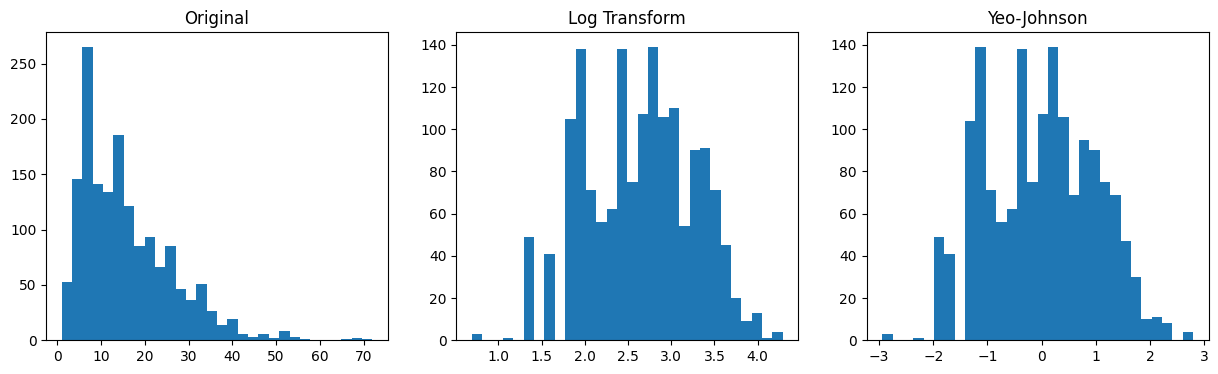

In [37]:
from sklearn.preprocessing import PowerTransformer

# Log transform of right-skewed 'free sulfur dioxide'
X['log_freesulfur'] = np.log1p(X['free sulfur dioxide'])

# Box-Cox requires positive values
pt = PowerTransformer(method='yeo-johnson')
X['yb_freesulfur'] = pt.fit_transform(X[['free sulfur dioxide']])

# Compare distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(X['free sulfur dioxide'], bins=30); axes[0].set_title('Original')
axes[1].hist(X['log_freesulfur'], bins=30); axes[1].set_title('Log Transform')
axes[2].hist(X['yb_freesulfur'], bins=30); axes[2].set_title('Yeo-Johnson')
plt.show()

#Learning:
#Why: Stabilizes variance and normalizes skewed distributions.
#Impact: Enables algorithms that assume normality (e.g., linear models, PCA) to perform better.

Feature Scaling Goal: All features contribute equally by adjusting their ranges or distributions

Cell 1: Load Breast Cancer Dataset

In [38]:
# STEP 1: Load dataset and inspect original features

from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the built-in dataset from sklearn
data_bc = load_breast_cancer()

# Create DataFrame with column names
df_bc = pd.DataFrame(data_bc.data, columns=data_bc.feature_names)

# Show a few records to understand raw data
print("Feature sample (before scaling):")
print(df_bc.head())


Feature sample (before scaling):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture

Cell 2: Apply Min-Max & Z-Score Scaling

In [39]:
# 🔹 STEP 2: Apply Min-Max Scaling and Z-Score Standardization

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize scalers
scaler_minmax = MinMaxScaler()
scaler_zscore = StandardScaler()

# Fit and transform the dataset
df_minmax = pd.DataFrame(scaler_minmax.fit_transform(df_bc), columns=data_bc.feature_names)
df_zscore = pd.DataFrame(scaler_zscore.fit_transform(df_bc), columns=data_bc.feature_names)

# Compare one sample before and after scaling
print("Before Scaling (1st record):")
print(df_bc.iloc[0])

print("\n After Min-Max Scaling:")
print(df_minmax.iloc[0])

print("\n After Z-score Scaling:")
print(df_zscore.iloc[0])

Before Scaling (1st record):
mean radius                  17.990000
mean texture                 10.380000
mean perimeter              122.800000
mean area                  1001.000000
mean smoothness               0.118400
mean compactness              0.277600
mean concavity                0.300100
mean concave points           0.147100
mean symmetry                 0.241900
mean fractal dimension        0.078710
radius error                  1.095000
texture error                 0.905300
perimeter error               8.589000
area error                  153.400000
smoothness error              0.006399
compactness error             0.049040
concavity error               0.053730
concave points error          0.015870
symmetry error                0.030030
fractal dimension error       0.006193
worst radius                 25.380000
worst texture                17.330000
worst perimeter             184.600000
worst area                 2019.000000
worst smoothness              0.162

Cell 3: Visualize the Scaling Effect

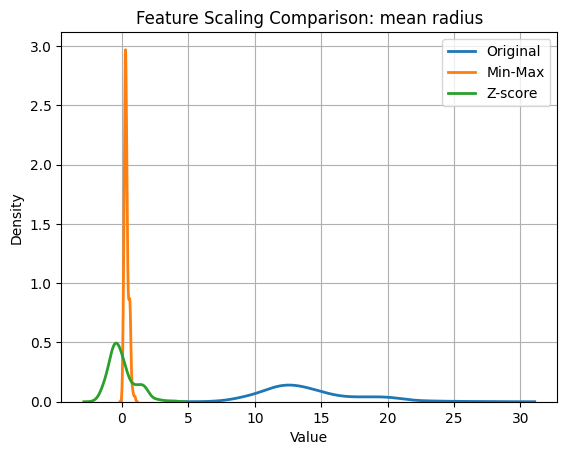

In [40]:
# STEP 3: Visualize the effect of scaling on one feature (mean radius)
import warnings                        # To suppress warnings (for cleaner output)

# FutureWarning is a harmless warning from Seaborn. Let's suppress it.
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.kdeplot(df_bc['mean radius'], label='Original', linewidth=2)
sns.kdeplot(df_minmax['mean radius'], label='Min-Max', linewidth=2)
sns.kdeplot(df_zscore['mean radius'], label='Z-score', linewidth=2)
plt.title("Feature Scaling Comparison: mean radius")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

#This plot shows how one feature, mean radius, is transformed by each method. We can see that:
#Min-Max squashes it between 0 and 1.
#Z-score centers the data around 0.
#The shape stays the same, but the scale changes."

Cell 4: Show Impact on Euclidean Distance

In [41]:
# STEP 4: See how distance between samples is affected by scaling

from scipy.spatial.distance import euclidean

# Select two samples from the original data
x1_raw = df_bc.iloc[0]
x2_raw = df_bc.iloc[1]

# Corresponding scaled values
x1_minmax = df_minmax.iloc[0]
x2_minmax = df_minmax.iloc[1]

x1_zscore = df_zscore.iloc[0]
x2_zscore = df_zscore.iloc[1]

# Calculate Euclidean distances
print("Euclidean Distance (Original):", euclidean(x1_raw, x2_raw))
print("Euclidean Distance (Min-Max):", euclidean(x1_minmax, x2_minmax))
print("Euclidean Distance (Z-score):", euclidean(x1_zscore, x2_zscore))
#The raw distance is much higher than the scaled distances.
#Algorithms like KNN or KMeans rely heavily on distance, so unscaled data can cause features with large ranges to dominate the result.

Euclidean Distance (Original): 341.7302620944424
Euclidean Distance (Min-Max): 1.4998292601165726
Euclidean Distance (Z-score): 10.318497148935617


#Impact on Proximity Metrics
Goal: Observe distance changes before vs after scaling.

#Wine Quality data set(worked on  earlier)

In [42]:
from scipy.spatial.distance import euclidean

# Compute distance before/after scaling for two samples
dist_raw = euclidean(X_train_raw.iloc[0], X_train_raw.iloc[1])
dist_mm = euclidean(X_train_mm[0], X_train_mm[1])
dist_ss = euclidean(X_train_ss[0], X_train_ss[1])

print(f"Euclidean distances:\n Raw: {dist_raw:.2f}\n Min-Max: {dist_mm:.2f}\n Z-score: {dist_ss:.2f}")

#Learning:
#Why: Distance measures are key in clustering/KNN; scaling ensures no single feature dominates.
#Impact: Ensures fair and accurate similarity assessment among points.

Euclidean distances:
 Raw: 2.92
 Min-Max: 0.37
 Z-score: 2.48


Summary of Learning Outcomes:-
# Discretization simplifies data, improves interpretability, and adds categorical features.
# Binarization adds logical flags for key thresholds.
# Normalization & Standardization align feature scales to improve model performance, especially in KNN/KMeans.
# Smoothing extracts meaningful trends from noisy data.
# Attribute transformations handle skewed data, enabling better model assumptions and performance.
# Proximity metrics demonstrate why scaling matters in similarity-based algorithms.